<a href="https://colab.research.google.com/github/PranavBK1/Cartoon-Conversion/blob/main/Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
PyTorch version 2.5.1+cu124
Torchvision version 0.20.1+cu124
Numpy version 1.26.4
Pandas version 2.2.2


Step 1. Pytorch Dataset (and Dataloader)


In [12]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

    @property
    def classes(self):
        return self.data.classes


In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification")

print("Path to dataset files:", path)

100%|██████████| 385M/385M [00:09<00:00, 42.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


In [21]:
dataset = PlayingCardDataset(
    data_dir= r'/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2'

)

In [22]:
len(dataset)

8154

1


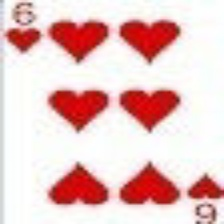

In [23]:
image, label = dataset[6000]
print(label)
image

In [24]:
# Get a dictionary associating target values with folder names
data_dir= r'/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'test', 1: 'train', 2: 'valid'}


In [26]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])
data_dir= r'/root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2'
dataset = PlayingCardDataset(data_dir, transform)

In [27]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [28]:
# iterate over dataset
for image, label in dataset:
    break

Dataloaders
Batching our dataset
It's faster to train the model in batches instead of one at a time

In [30]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [31]:
for images, labels in dataloader:
    break

In [32]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

Step 2. Pytorch Model

In [33]:
class SimpleCardClassifer(nn.Module):
    def __init__(self, num_classes=53):
        super(SimpleCardClassifer, self).__init__()
        # Where we define all the parts of the model
        self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])

        enet_out_size = 1280
        # Make a classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )

    def forward(self, x):
        # Connect these parts and return the output
        x = self.features(x)
        output = self.classifier(x)
        return output

In [34]:
model = SimpleCardClassifer(num_classes=53)
print(str(model)[:500])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

SimpleCardClassifer(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fal


In [35]:
example_out = model(images)
example_out.shape # [batch_size, num_classes]

torch.Size([32, 53])

Step 3. The training loop

In [36]:
# Loss function
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
criterion(example_out, labels)
print(example_out.shape, labels.shape)

torch.Size([32, 53]) torch.Size([32])


Setup Datasets

In [39]:
from google.colab import files

# Upload kaggle.json
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pranavbk0","key":"ff56bc886eb87fcea3013596980f0b5e"}'}

In [40]:
import os

# Create .kaggle folder and move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions

print("✅ Kaggle API is set up!")


✅ Kaggle API is set up!


In [41]:
# Download dataset from Kaggle and unzip it
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification --unzip -p /content/
print("✅ Dataset downloaded and extracted!")


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
 98% 379M/385M [00:05<00:00, 99.2MB/s]
100% 385M/385M [00:05<00:00, 73.2MB/s]
✅ Dataset downloaded and extracted!


In [42]:
import shutil

# Define paths
source_path = "/content/train"  # Adjust this if needed
destination_path = "/content/training_folder"

# Move dataset to training folder
if os.path.exists(source_path):
    shutil.move(source_path, destination_path)
    print("✅ Dataset moved to:", destination_path)
else:
    print("❌ Source path not found. Check dataset structure.")


✅ Dataset moved to: /content/training_folder


In [46]:
import os

# Check dataset files
print("📂 Training Folder Content:", os.listdir("/content/training_folder"))

# Now, use this dataset in your code
train_folder = r"/content/training_folder"
print("✅ Dataset loaded successfully!")

📂 Training Folder Content: ['ten of hearts', 'queen of diamonds', 'three of hearts', 'seven of diamonds', 'five of diamonds', 'seven of clubs', 'six of spades', 'ten of clubs', 'four of clubs', 'two of spades', 'eight of clubs', 'two of diamonds', 'seven of spades', 'joker', 'eight of hearts', 'ten of spades', 'six of diamonds', 'four of spades', 'six of clubs', 'eight of spades', 'three of diamonds', 'ace of clubs', 'eight of diamonds', 'five of spades', 'nine of clubs', 'jack of spades', 'three of spades', 'four of hearts', 'jack of clubs', 'five of clubs', 'six of hearts', 'jack of hearts', 'ten of diamonds', 'two of hearts', 'ace of spades', 'king of clubs', 'queen of clubs', 'king of spades', 'two of clubs', 'four of diamonds', 'jack of diamonds', 'ace of diamonds', 'ace of hearts', 'seven of hearts', 'queen of spades', 'three of clubs', 'nine of diamonds', 'queen of hearts', 'nine of hearts', 'five of hearts', 'king of hearts', 'king of diamonds', 'nine of spades']
✅ Dataset load

In [47]:
import shutil

# Define source and destination paths
source_path = "/content/valid"  # This is where Kaggle extracted the files
destination_path = "/content/valid_folder"

# Move dataset to the valid folder
if os.path.exists(source_path):
    shutil.move(source_path, destination_path)
    print("✅ Validation dataset moved to:", destination_path)
else:
    print("❌ Source path not found. Check dataset structure.")


✅ Validation dataset moved to: /content/valid_folder


In [48]:
import os

# Check dataset files
print("📂 Validation Folder Content:", os.listdir("/content/valid_folder"))

# Now, use this dataset in your code
valid_folder = "/content/valid_folder"
print("✅ Validation dataset loaded successfully!")


📂 Validation Folder Content: ['ten of hearts', 'queen of diamonds', 'three of hearts', 'seven of diamonds', 'five of diamonds', 'seven of clubs', 'six of spades', 'ten of clubs', 'four of clubs', 'two of spades', 'eight of clubs', 'two of diamonds', 'seven of spades', 'joker', 'eight of hearts', 'ten of spades', 'six of diamonds', 'four of spades', 'six of clubs', 'eight of spades', 'three of diamonds', 'ace of clubs', 'eight of diamonds', 'five of spades', 'nine of clubs', 'jack of spades', 'three of spades', 'four of hearts', 'jack of clubs', 'five of clubs', 'six of hearts', 'jack of hearts', 'ten of diamonds', 'two of hearts', 'ace of spades', 'king of clubs', 'queen of clubs', 'king of spades', 'two of clubs', 'four of diamonds', 'jack of diamonds', 'ace of diamonds', 'ace of hearts', 'seven of hearts', 'queen of spades', 'three of clubs', 'nine of diamonds', 'queen of hearts', 'nine of hearts', 'five of hearts', 'king of hearts', 'king of diamonds', 'nine of spades']
✅ Validation

In [ ]:
import shutil

# Define source and destination paths
source_path = "/content/valid"  # This is where Kaggle extracted the files
destination_path = "/content/valid_folder"

# Move dataset to the valid folder
if os.path.exists(source_path):
    shutil.move(source_path, destination_path)
    print("✅ Validation dataset moved to:", destination_path)
else:
    print("❌ Source path not found. Check dataset structure.")


In [49]:
import shutil

# Define source and destination paths
source_path = "/content/test"  # This is where Kaggle extracted the files
destination_path = "/content/test_folder"

# Move dataset to the test folder
if os.path.exists(source_path):
    shutil.move(source_path, destination_path)
    print("✅ Test dataset moved to:", destination_path)
else:
    print("❌ Source path not found. Check dataset structure.")


✅ Test dataset moved to: /content/test_folder


In [91]:
import os

# Check dataset files
print("📂 Test Folder Content:", os.listdir("/content/test_folder"))

# Now, use this dataset in your code
test_folder = "/content/test_folder"
print("✅ Test dataset loaded successfully!")


📂 Test Folder Content: ['ten of hearts', 'queen of diamonds', 'three of hearts', 'seven of diamonds', 'five of diamonds', 'seven of clubs', 'six of spades', 'ten of clubs', 'four of clubs', 'two of spades', 'eight of clubs', 'two of diamonds', 'seven of spades', 'joker', 'eight of hearts', 'ten of spades', 'six of diamonds', 'four of spades', 'six of clubs', 'eight of spades', 'three of diamonds', 'ace of clubs', 'eight of diamonds', 'five of spades', 'nine of clubs', 'jack of spades', 'three of spades', 'four of hearts', 'jack of clubs', 'five of clubs', 'six of hearts', 'jack of hearts', 'ten of diamonds', 'two of hearts', 'ace of spades', 'king of clubs', 'queen of clubs', 'king of spades', 'two of clubs', 'four of diamonds', 'jack of diamonds', 'ace of diamonds', 'ace of hearts', 'seven of hearts', 'queen of spades', 'three of clubs', 'nine of diamonds', 'queen of hearts', 'nine of hearts', 'five of hearts', 'king of hearts', 'king of diamonds', 'nine of spades']
✅ Test dataset loa

In [51]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])


train_dataset = PlayingCardDataset(train_folder, transform=transform)
val_dataset = PlayingCardDataset(valid_folder, transform=transform)
test_dataset = PlayingCardDataset(test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Simple Training Loop


In [52]:
# Simple training loop
num_epochs = 5
train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = SimpleCardClassifer(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc='Training loop'):
        # Move inputs and labels to the device
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    # Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc='Validation loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")

Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Train loss: 1.5262010269500277, Validation loss: 0.3362879213297142


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Train loss: 0.5304550181405867, Validation loss: 0.2524044891573348


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Train loss: 0.31710242465185345, Validation loss: 0.20561742265269442


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Train loss: 0.25456013741579536, Validation loss: 0.2101376829282293


Training loop:   0%|          | 0/239 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Train loss: 0.1682486753414335, Validation loss: 0.18943516898829982


Visualize Losses

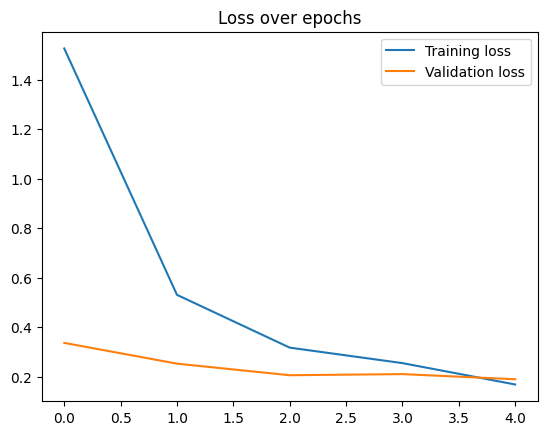

In [53]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

Bonus: Evaluating the Results

In [86]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()
# visualisation
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()
# Example usage
test_image = r'WhatsApp Image 2025-03-12 at 16.40.50_aa016276.jpg'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()])

In [88]:
from PIL import Image
import torchvision.transforms as transforms

# Load image and ensure it's in RGB format
image_path = r'WhatsApp Image 2025-03-12 at 16.40.50_aa016276.jpg'
image = Image.open(image_path).convert("RGB")  # Convert to RGB to remove alpha channel

# Apply transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match model input
    transforms.ToTensor(),          # Convert to tensor
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

print("✅ Image preprocessed successfully:", image_tensor.shape)


✅ Image preprocessed successfully: torch.Size([1, 3, 128, 128])


In [98]:
print("Total test images:", len(test_images))
print("First 5 test images:", test_images[:5])  # Print first 5 images


Total test images: 53
First 5 test images: ['/content/test_folder/ten of hearts', '/content/test_folder/queen of diamonds', '/content/test_folder/three of hearts', '/content/test_folder/seven of diamonds', '/content/test_folder/five of diamonds']


In [99]:
num_samples = min(10, len(test_images))  # Choose the smaller value
test_examples = np.random.choice(test_images, num_samples, replace=False)  # Ensure valid sampling


In [103]:
from glob import glob
import numpy as np

# Get all image files
test_images = glob('/content/test_folder/*/*.jpg')  # Adjust for your file format

# Debugging: Print the first few file paths
print("🔍 Test images found:", test_images[:5])  # Print first 5 images to check

if not test_images:  # Check if images were found
    print("❌ No images found in test folder! Check directory structure.")
else:
    print("✅ Found", len(test_images), "test images.")

# Now safely select images
num_samples = min(10, len(test_images))  # Ensure valid sampling

if num_samples == 0:
    raise ValueError("❌ No valid images found for testing!")

test_examples = np.random.choice(test_images, num_samples, replace=False)

for example in test_examples:
    print("📷 Processing:", example)  # Debugging: Print image being processed

    original_image, image_tensor = preprocess_image(example, transform)

    print("🖼 Image tensor shape:", image_tensor.shape)  # Debug tensor shape

    probabilities = predict(model, image_tensor, device)

    class_names = dataset.classes
    print("📊 Predicted probabilities:", probabilities)  # Debugging






🔍 Test images found: ['/content/test_folder/ten of hearts/4.jpg', '/content/test_folder/ten of hearts/3.jpg', '/content/test_folder/ten of hearts/1.jpg', '/content/test_folder/ten of hearts/5.jpg', '/content/test_folder/ten of hearts/2.jpg']
✅ Found 265 test images.
📷 Processing: /content/test_folder/king of clubs/3.jpg
🖼 Image tensor shape: torch.Size([1, 3, 128, 128])
📊 Predicted probabilities: [2.41566545e-09 1.62086854e-11 1.84165096e-12 3.41463706e-12
 1.40115057e-08 1.61233895e-12 1.08215886e-13 1.38677572e-14
 4.32439397e-11 6.11975748e-14 1.15672206e-15 3.52832972e-15
 1.05432918e-07 3.05319485e-11 2.47418362e-12 7.43885639e-13
 7.01264380e-10 1.68974494e-13 1.27059491e-11 2.69459802e-12
 4.72933415e-10 9.99994636e-01 1.86955340e-09 1.23135862e-07
 1.04538378e-08 2.12524402e-13 1.89858064e-14 1.52731452e-13
 2.09912959e-14 2.95094452e-07 3.63888052e-11 5.31823335e-11
 1.56536969e-12 4.23923619e-13 9.73991734e-14 5.28803509e-13
 2.23893021e-15 1.71130665e-10 3.90715927e-15 4.769

📷 Processing: /content/test_folder/king of clubs/3.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/ace of hearts/2.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/jack of spades/1.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/nine of clubs/4.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/three of clubs/5.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/seven of spades/4.jpg
📊 Probabilities shape: (53,)
❌ Mismatch between probabilities and class names! Skipping image.
📷 Processing: /content/test_folder/nine of hearts/4.jpg
📊 Probabilities shape: (53,)
❌ Mismatch 

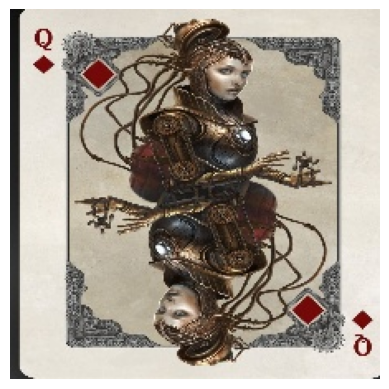

In [105]:
import matplotlib.pyplot as plt

for example in test_examples:
    print("📷 Processing:", example)  # Debugging: Print image being processed

    # Preprocess image
    original_image, image_tensor = preprocess_image(example, transform)

    # Display the image
    plt.imshow(original_image)
    plt.axis("off")

    # Get predictions
    probabilities = predict(model, image_tensor, device)

    # Debugging: Check if probabilities are valid
    print("📊 Probabilities shape:", probabilities.shape)

    # Ensure probabilities have values
    if probabilities is None or len(probabilities) == 0:
        print("❌ No valid probabilities found! Skipping image.")
        continue

    # Ensure dataset classes exist
    if not hasattr(dataset, 'classes') or not dataset.classes:
        print("❌ No class labels found! Check dataset.")
        continue

    class_names = dataset.classes

    # Check if probabilities and class names match
    if probabilities.shape[0] != len(class_names):
        print("❌ Mismatch between probabilities and class names! Skipping image.")
        continue

    # Get the top prediction
    predicted_class = class_names[probabilities.argmax()]
    confidence = probabilities.max() * 100  # Convert to percentage

    # Set title with prediction
    plt.title(f"Prediction: {predicted_class} ({confidence:.2f}%)", fontsize=14)

    # Show the image
    plt.show()


In [106]:
import torch
from torch.utils.data import DataLoader

# Ensure the model is in evaluation mode
model.eval()

correct = 0
total = 0

# Use DataLoader to iterate over the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

with torch.no_grad():  # Disable gradient computation for evaluation
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to GPU if available

        # Get predictions
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability

        # Update counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Compute accuracy
accuracy = (correct / total) * 100
print(f"✅ Model Accuracy: {accuracy:.2f}%")


✅ Model Accuracy: 93.96%
